In [1]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyjet import cluster

from scipy.stats import binned_statistic_2d

In [2]:
filePath = "data/4m_samples.h5"
nJets = 500
nConstituents = 40
R0 = 0.2
p = -1

In [3]:
def _load (filePath,nJets,nConstituents):
    cols = ['E_'+str(i) for i in range(nConstituents)]+ ['PX_'+str(i) for i in range(nConstituents)] + ['PX_'+str(i) for i in range(nConstituents)] + ['PY_'+str(i) for i in range(nConstituents)] + ['PZ_'+str(i) for i in range(nConstituents)] + ['is_signal_new']
    df = pd.read_hdf(filePath,key='data',stop=nJets, columns = cols)
    momenta = df.iloc[:,:-1].to_numpy()
    momenta = momenta.reshape(-1,nConstituents,4)
    nJets = slice(nJets)
    momenta = momenta[nJets, :nConstituents, :]
    momenta = np.transpose(momenta, (0, 2, 1))
    labels = df['is_signal_new'].to_numpy()
    return momenta, labels


In [4]:
momenta, labels = _load(filePath,nJets,nConstituents)

In [5]:
def _getFeatures (momenta,nConstituents):
    # Jet features
    jetMomenta = np.sum(momenta, axis=2)
    jetPt = np.linalg.norm(jetMomenta[:, 1:3], axis=1)[..., np.newaxis]
    jetE = jetMomenta[:, 0][..., np.newaxis]
    jetP = np.linalg.norm(jetMomenta[:, 1:], axis=1)
    jetEta = 0.5 * np.log((jetP + jetMomenta[:, 3]) / (jetP - jetMomenta[:, 3]))[..., np.newaxis]
    jetPhi = np.arctan2(jetMomenta[:, 2], jetMomenta[:, 1])[..., np.newaxis]
    jetTheta = 2*np.arctan(np.exp(-jetEta))
    # Copy nConstituents times to match the shape (nJets, nConstituents).
    jetPt = np.tile(jetPt,nConstituents)
    jetE = np.tile(jetE,nConstituents)
    jetEta = np.tile(jetEta,nConstituents)
    jetPhi = np.tile(jetPhi,nConstituents)

    # Constituent features
    # delta eta, delta phi, log pT, log E,log pT / pTjet, log E / Ejet, delta R
    pT = np.linalg.norm(momenta[:, 1:3, :], axis=1)
    e = momenta[:, 0, :]
    p = np.linalg.norm(momenta[:, 1:, :], axis=1)
    mass = e**2- p**2
    # eta = 0.5 * np.log((p + momenta[:, 3, :]) / (p - momenta[:, 3, :]))
    eta = np.arcsinh(momenta[:,3,:]/pT)
    etaRel = eta - jetEta
    phi = np.arctan2(momenta[:, 2, :], momenta[:, 1, :])
    phiRel = np.unwrap(phi - jetPhi)
    dR = np.sqrt(phi ** 2 + eta ** 2)
    theta = 2*np.arctan(np.exp(-eta))
    cosThetaRel = np.cos(theta-jetTheta)
    
    # Concatenate
    # features = np.stack([jetPt, jetE, jetEta, jetPhi, pT, mass, e, eta, etaRel, phi, phiRel, dR, cosThetaRel],axis=-1)
    features = np.stack([pT,eta,phi,mass, etaRel, phiRel, e, dR, cosThetaRel, jetPt, jetE, jetEta, jetPhi],axis=-1)
    return features


In [6]:
features = _getFeatures(momenta,nConstituents)
features.shape

(500, 40, 13)

In [7]:
def deltaPhi(phi1,phi2):
    # Make sure it in the range (-pi, pi)
    x = phi1-phi2
    while x>= np.pi: x -= np.pi*2.
    while x< -np.pi: x += np.pi*2.
    return x

def rotate(x, y, a):
    xp = x * np.cos(a) - y * np.sin(a)
    yp = x * np.sin(a) + y * np.cos(a)
    return xp, yp

def _clusterAndRotate (event, R0, ep=False, p=-1):
    '''
    R: Clustering radius for the main jets
    p = -1, 0, 1 => anti-kt, C/A, kt Algorithm
    ep = False, True => (px,py,pz,e) , (pT,eta,phi,mass)
    '''
    flattened_event = np.core.records.fromarrays( [event[:,0],event[:,1],event[:,2],event[:,3]], names= 'pT, eta, phi, mass' , formats = 'f8, f8, f8,f8')
    sequence = cluster(flattened_event, R=R0, p= p)
    jets = sequence.inclusive_jets()

    if len(jets)<2:
        return []
    else:
        subjet_data = event
        subjet_array = jets

    pT = subjet_data[:, 0]
    eta = subjet_data[:, 1]
    phi = subjet_data[:, 2]
    mass = subjet_data[:, 3]

    # shifts all data with respect to the leading subjet so that
    # the Jet Image is centerd at the origin (eta,phi) = (0,0).
    eta -= subjet_array[0].eta
    phi = np.array( [deltaPhi(i,subjet_array[0].phi) for i in phi])

    # Rotate the jet image such that the second leading
    # subjet is located at -pi/2
    s1x, s1y = subjet_array[1].eta - subjet_array[0].eta, deltaPhi(subjet_array[1].phi,subjet_array[0].phi)

    theta = np.arctan2(s1y, s1x)
    if theta < 0.0:
        theta += 2 * np.pi
    etaRot, phiRot = rotate(eta, phi, np.pi - theta)
    
    return etaRot, phiRot

In [8]:
etaRot = []
phiRot = []
for i in tqdm(range(nJets)):
    event = features[i,:,:4]
    eta_R,phi_R = _clusterAndRotate(event,R0)
    etaRot.append(eta_R)
    phiRot.append(phi_R)
etaRot = np.array(etaRot)
phiRot = np.array(phiRot)

100%|██████████| 500/500 [00:00<00:00, 4717.84it/s]


In [9]:
validIndices = np.where(features[:,:,0]!=0)
etaRot = etaRot[validIndices[0],validIndices[1]]
phiRot = phiRot[validIndices[0],validIndices[1]]
pT = features[validIndices[0],validIndices[1],0]


In [10]:
R=1.2
bins=64
ranges = np.array([[-R,R],[-R,R]])

# Sum energy deposits in each bin
digitized = binned_statistic_2d(etaRot, phiRot, pT, statistic="sum", bins=bins, range= ranges)
jet_image = digitized.statistic

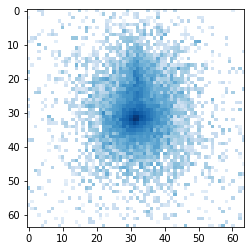

In [11]:
plt.imshow(np.log(jet_image),  cmap = 'Blues')

In [88]:
etaRot.shape

(3568,)

In [86]:
features.shape

(100, 40, 13)

In [77]:
a = np.array([[1,2,3,0],
     [4,5,6,0],
     [7,0,8,9]])

In [78]:
np.where(a!=0)

(array([0, 0, 0, 1, 1, 1, 2, 2, 2]), array([0, 1, 2, 0, 1, 2, 0, 2, 3]))

In [79]:
a[np.where(a!=0)[0],np.where(a!=0)[1]]

array([1, 2, 3, 4, 5, 6, 7, 8, 9])